In [532]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

In [534]:
amazon_df = pd.read_csv(r"/Users/iqrabismi/Desktop/amazon_close (1).csv")

In [535]:
amazon_df.head(5)

,date,close
0,2019-02-08,1588.22
1,2019-02-07,1614.37
2,2019-02-06,1640.26
3,2019-02-05,1658.81
4,2019-02-04,1633.31


###  EDA and Data Preprocessing

In [536]:
len(amazon_df)

1259

In [537]:
amazon_df.isna().sum()

date     0
close    0
dtype: int64

In [538]:
len(amazon_df[amazon_df.duplicated()]==True)

0

In [539]:
amazon_df.dtypes

date      object
close    float64
dtype: object

In [540]:
## changing data to datetime 

In [541]:
amazon_df['date'] = pd.to_datetime(amazon_df['date'])

In [542]:
### finding the start and end date

In [543]:
amazon_df.date.min(), amazon_df.date.max()

(Timestamp('2014-02-10 00:00:00'), Timestamp('2019-02-08 00:00:00'))

In [544]:
amazon_df.describe()

,close
count,1259.000000
mean,849.730116
std,486.737426
min,286.950000
25%,425.740000
50%,752.610000
75%,1121.915000
max,2039.510000


In [545]:
amazon_df.set_index('date',inplace=True)

<AxesSubplot:>

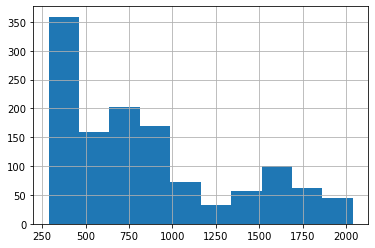

In [546]:
amazon_df.close.hist() # data is right skewed 

<AxesSubplot:xlabel='date'>

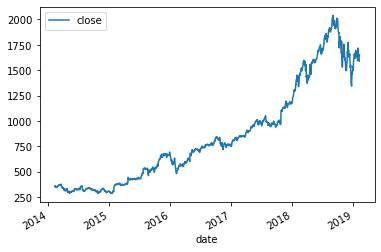

In [547]:
amazon_df.plot(kind='line')

##### To implement ARIMA Model data has to be stationary and from the graph above we can see that data is not stationary. Also, variance and auto correlation should be constant

### Checking data is stationary or not via Dicky-Fuller Test

In [548]:
# Null hypothesis is time series is non-stationary

In [549]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(amazon_df['close'])

In [550]:
results

(-1.3446690965326056,
 0.6084966311408377,
 23,
 1235,
 {'1%': -3.4356560275160835,
  '5%': -2.8638831211270817,
  '10%': -2.568017509711682},
 10782.877783880944)

p-value is 0.6 which is greater than significant value i.e. 0.5. Hence, we cannot reject null hypothesis. 

#### Making the timeseries stationary 

In [551]:
amazon_df_stationary= amazon_df.diff()

In [552]:
amazon_df_stationary.dropna(inplace=True)

<AxesSubplot:xlabel='date'>

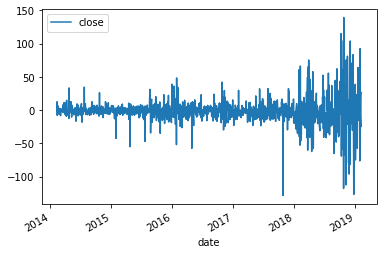

In [553]:
amazon_df_stationary.plot(kind='line')

In [554]:
### implementing the Dicky-Fuller Test

results = adfuller(amazon_df_stationary['close'])

In [555]:
results

(-7.2035794888112425,
 2.331271725487213e-10,
 23,
 1234,
 {'1%': -3.435660336370594,
  '5%': -2.863885022214541,
  '10%': -2.568018522153254},
 10764.626718933836)

Here, p value is less than 0.05. Hence, we can reject the null hypothesis and data is stationary.

### Finding the order of differencing using ADFuller Test. 
Null Hypothesis: data is stationary

In [556]:
adf = adfuller(amazon_df_stationary.iloc[:,0])
print('ADF Statistic:', adf[0])
print('p-value:', adf[1]) ## Hence data is not yet stationary, we need to differentiate further

ADF Statistic: -7.2035794888112425
p-value: 2.331271725487213e-10


#### Removing the outlier

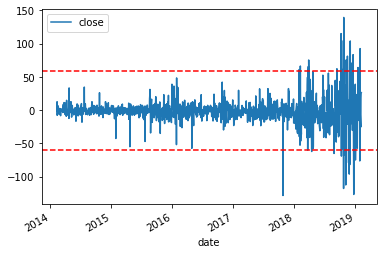

In [557]:
## Finding Outliers in the data

this_mean = amazon_df_stationary.close.mean()
this_std = amazon_df_stationary.close.std()
# Plot the data, with a window that is 3 standard deviations
# around the mean
amazon_df_stationary.plot()
plt.axhline(this_mean + this_std * 3, ls='--', c='r')
plt.axhline(this_mean - this_std * 3, ls='--', c='r')
plt.show()

In [558]:
## Replacing the outliers
outliers = np.abs(this_mean) + (this_std * 2)
outliers1 = np.abs(this_mean) - (this_std * 2)

In [559]:
amazon_df_stationary['close']= np.where(amazon_df_stationary.close> outliers, amazon_df_stationary.close.median(), amazon_df_stationary.close)

In [560]:
amazon_df_stationary['close']= np.where(amazon_df_stationary.close< outliers1, amazon_df_stationary.close.median(), amazon_df_stationary.close)

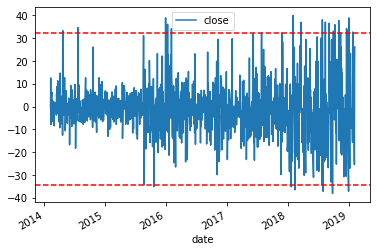

In [561]:
## Finding Outliers in the data

this_mean = amazon_df_stationary.close.mean()
this_std = amazon_df_stationary.close.std()
# Plot the data, with a window that is 3 standard deviations
# around the mean
amazon_df_stationary.plot()
plt.axhline(this_mean + this_std * 3, ls='--', c='r')
plt.axhline(this_mean - this_std * 3, ls='--', c='r')
plt.show()

<AxesSubplot:ylabel='Frequency'>

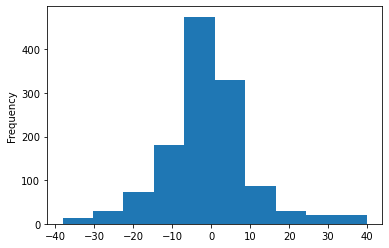

In [562]:
amazon_df_stationary.close.plot(kind='hist')

### Implementing the ARIMA Models 

ARIMA (AutoRegressive Integrated Moving Average) is a statistical model that can be used for time series forecasting. The "ARIMA" part of the name refers to the three components of the model: the autoregression (AR) component, the differencing (I) component, and the moving average (MA) component.

The order of an ARIMA model refers to the number of lags included in the autoregression and moving average components of the model, and the number of times the data has been differenced. The order of an ARIMA model is denoted by the notation (p,d,q), where p is the order of the autoregression component, d is the order of the differencing component, and q is the order of the moving average component.

One way to determine the order of an ARIMA model is by using the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots of the time series data.

The ACF plot shows the correlation between a time series and lagged versions of itself, whereas the PACF plot shows the correlation between a time series and lagged versions of itself that are not explained by the previous lags.

If the ACF plot decays gradually and the PACF plot cuts off after a few lags, it suggests that the time series data is best modeled with an MA(q) component.

If the PACF plot decays gradually and the ACF plot cuts off after a few lags, it suggests that the time series data is best modeled with an AR(p) component.

If the ACF and PACF plots both decay gradually, it suggests that the time series data is best modeled with an ARIMA(p,d,q) component, where d is the number of times the data has been differenced to make it stationary.

In [393]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


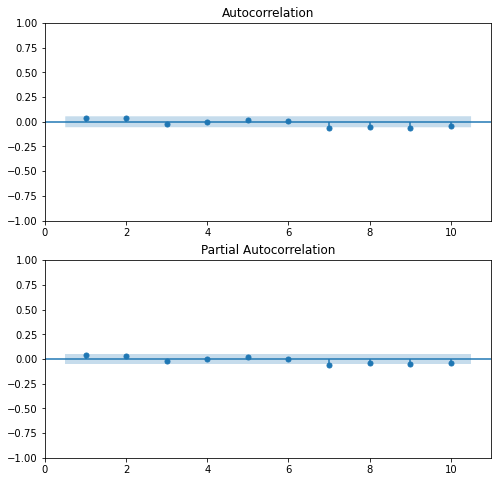

In [481]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
plot_acf(amazon_df_stationary.close, lags=10, zero=False, ax=ax1)
plot_pacf(amazon_df_stationary.close, lags=10, zero=False, ax=ax2)
plt.show()

##### In the above graph both ACF and PACF tails off so its ARMA 

#### Finding the order for ARMA Model

AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) are two statistical measures that can be used to compare different models and determine which one is the best fit for a given dataset.

Both AIC and BIC are based on the likelihood of the data given the model, but they also take into account the complexity of the model. AIC rewards models with a higher likelihood but punishes them for having more parameters, while BIC rewards models with a higher likelihood but also punishes them more severely for having more parameters.

The difference between these two metrics is how much they penalize model complexity. The BIC penalizes additional model orders more than AIC and so the BIC will sometimes suggest a simpler model. The AIC and BIC will often choose the same model, but when they don't we will have to make a choice. If our goal is to identify good predictive models, we should use AIC. However if our goal is to identify a good explanatory model, we should use BIC.

In [482]:
from statsmodels.tsa.arima.model import ARIMA


In [483]:
order_aic_bic =[]
# Loop over AR order
for p in range(3):
# Loop over MA order
    for q in range(3):
        # Fit model
        model = ARIMA(amazon_df_stationary.close, order=(p,0,q)) 
        results = model.fit()
        # Add order and scores to list
        order_aic_bic.append((p, q, results.aic, results.bic))

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-

In [484]:
# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p','q','aic','bic'])

In [485]:
order_df

,p,q,aic,bic
0,0,0,9012.260627,9022.535184
1,0,1,9012.752005,9028.163841
2,0,2,9012.899804,9033.448917
3,1,0,9012.641096,9028.052931
4,1,1,9013.977117,9034.526231
5,1,2,9014.462183,9040.148575
6,2,0,9013.064702,9033.613816
7,2,1,9014.558611,9040.245003
8,2,2,9013.892048,9044.715718


In [486]:
# Sort by AIC
print(order_df.sort_values('aic'))

   p  q          aic          bic
0  0  0  9012.260627  9022.535184
3  1  0  9012.641096  9028.052931
1  0  1  9012.752005  9028.163841
2  0  2  9012.899804  9033.448917
6  2  0  9013.064702  9033.613816
8  2  2  9013.892048  9044.715718
4  1  1  9013.977117  9034.526231
5  1  2  9014.462183  9040.148575
7  2  1  9014.558611  9040.245003


In [487]:
# Sort by BIC
print(order_df.sort_values('bic'))

   p  q          aic          bic
0  0  0  9012.260627  9022.535184
3  1  0  9012.641096  9028.052931
1  0  1  9012.752005  9028.163841
2  0  2  9012.899804  9033.448917
6  2  0  9013.064702  9033.613816
4  1  1  9013.977117  9034.526231
5  1  2  9014.462183  9040.148575
7  2  1  9014.558611  9040.245003
8  2  2  9013.892048  9044.715718


##### Hence AIC score is lowest for order 2,2 whereas BIC score is lowest for order 0,0. In this project, aim is find a good prediction model for stock prices. Hence, I will consider AIC score. So order is 2,2

### Model Diagnostic

In [488]:
model = ARIMA(amazon_df_stationary.close, order=(0,0,0))
results = model.fit()
# Assign residuals to variable
residuals = results.resid

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-

In [489]:
print(residuals)

date
2019-02-07    27.293359
2019-02-06    27.033359
2019-02-05    19.693359
2019-02-04   -24.356641
2019-02-01    -5.936641
                ...    
2014-02-14     4.843359
2014-02-13     0.993359
2014-02-12    -6.806641
2014-02-11    13.683359
2014-02-10     0.223359
Length: 1258, dtype: float64


In [490]:
mae = np.mean(np.abs(residuals))

In [491]:
print("mean absolute error is ",mae)

mean absolute error is  6.255346818455522


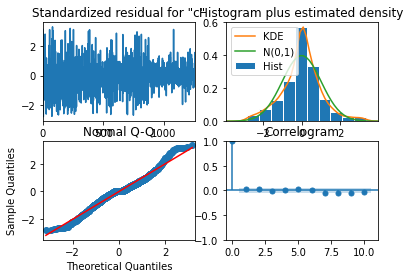

In [492]:
results.plot_diagnostics()
plt.show()

In [511]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1258
Model:                          ARIMA   Log Likelihood               -4504.130
Date:                Thu, 26 Jan 2023   AIC                           9012.261
Time:                        01:11:51   BIC                           9022.535
Sample:                             0   HQIC                          9016.122
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1434      0.245     -4.666      0.000      -1.624      -0.663
sigma2        75.4072      2.464     30.603      0.000      70.578      80.237
Ljung-Box (L1) (Q):                   1.61   Jarque-

Prob(Q) - p-value for null hypothesis that residuals are uncorrelated. 
Prob(JB) - p-value for null hypothesis that residuals are normal. 

So, we can see that Prob(Q) value is more than 0.05 so residuals are uncorrelated but p-value for Prob(JB) is less than 0.05 which tells us that residuals are not normally distributed. This may be due to seasonality in the data. For which I will implement SARIMAX model to evaluate the performance of the model. 

### SARIMAX Model

<AxesSubplot:xlabel='date'>

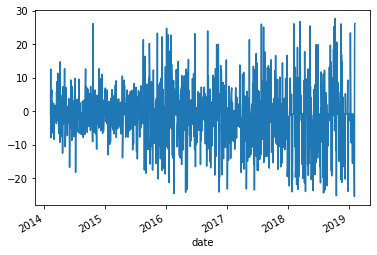

In [497]:
amazon_df_stationary.close.plot(kind='line')

In [688]:
# Import
from statsmodels.tsa.seasonal import seasonal_decompose

In [689]:
decomp_results = seasonal_decompose(amazon_df_stationary.close, period=12)

In [690]:
type(decomp_results)

statsmodels.tsa.seasonal.DecomposeResult

<Figure size 720x576 with 0 Axes>

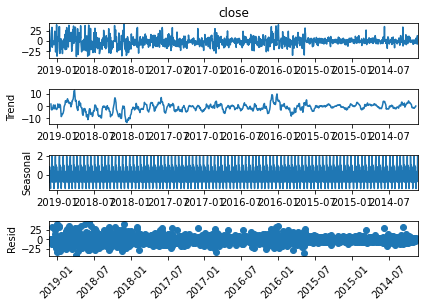

In [698]:
plt.figure(figsize=(10,8))
plt.subplots_adjust(hspace=0.5)

decomp_results.plot()
plt.xticks(rotation=45)
plt.show()

In [502]:
# Subtract long rolling average over N steps
df = amazon_df_stationary - amazon_df_stationary.rolling(12).mean()
# Drop NaN values
df = amazon_df_stationary.dropna()

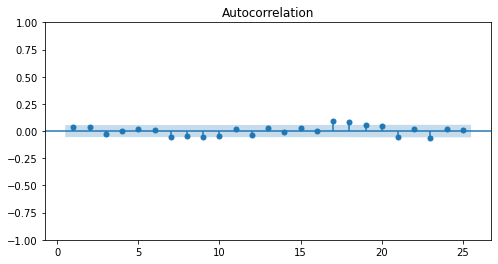

In [503]:
# Create figure
fig, ax = plt.subplots(1,1, figsize=(8,4))
# Plot ACF
plot_acf(df.close.dropna(), ax=ax, lags=25, zero=False)
plt.show()

In [414]:
## seasonal differencing 
df_diff = df.diff(12)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


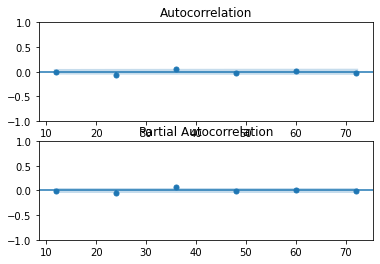

In [415]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1)
# Plot seasonal ACF
plot_acf(df.close, lags=[12,24,36,48,60,72], ax=ax1)
# Plot seasonal PACF
plot_pacf(df.close, lags=[12,24,36,48,60,72], ax=ax2)
plt.show()

In [683]:
### Searching for order of the model

import pmdarima as pm

In [684]:
results = pm.auto_arima(df.close,d=0, start_p = 0, start_q= 0 , max_p = 4, max_q= 4, 
                       seasonal=True,m=12,D=1, start_P= 1, start_Q= 1, max_P= 4, max_Q=4,
                       information_criterion= 'aic', trace= True, stepwise= True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=9819.833, Time=0.11 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=9423.606, Time=1.38 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.40 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=9817.833, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=9821.823, Time=0.34 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=9263.280, Time=4.34 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=9212.935, Time=8.83 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=9149.526, Time=12.78 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=inf, Time=26.89 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=16.43 sec
 ARIMA(0,0,0)(4,1,0)[12] intercept   : AIC=9148.731, Time=19.27 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=9213.386, Time=7.34 sec
 ARIMA(0,0,0)(4,1,1)[12] intercept   : AIC=inf, Time=17.48 sec
 ARIMA(0,0,0)(3,1,1)[12] intercept   : 

In [685]:
print(results.summary())

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                 1258
Model:             SARIMAX(4, 1, 0, 12)   Log Likelihood               -4568.374
Date:                  Fri, 27 Jan 2023   AIC                           9146.748
Time:                          12:54:40   BIC                           9172.387
Sample:                               0   HQIC                          9156.388
                                 - 1258                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.8324      0.025    -33.617      0.000      -0.881      -0.784
ar.S.L24      -0.6127      0.032    -18.952      0.000      -0.676      -0.549
ar.S.L36      -0.3834      0.032    

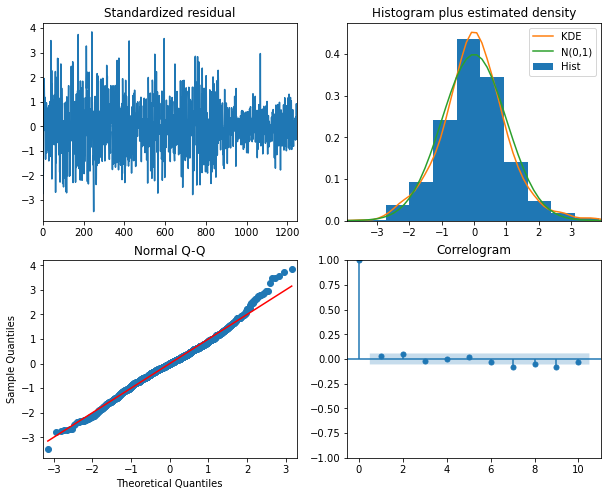

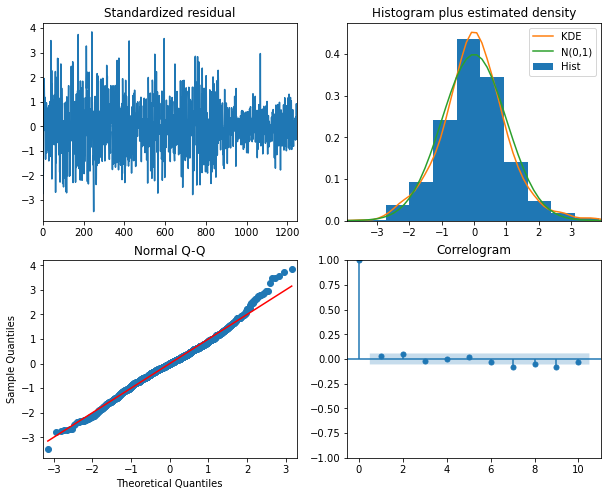

In [686]:
results.plot_diagnostics(figsize=(10, 8))

## Predictions 

In [668]:
### Train-test split

df_train = df.iloc[:800]
# Test data - all data from 2019 onwards
df_test = df.iloc[800:]

In [669]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [717]:
model = SARIMAX(df_train, order=(0,0,0), seasonal_order=(4,0,1,12))

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [718]:
results = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71244D+00    |proj g|=  3.07075D-02

At iterate    5    f=  3.71173D+00    |proj g|=  1.79214D-03

At iterate   10    f=  3.71166D+00    |proj g|=  9.36956D-04

At iterate   15    f=  3.71149D+00    |proj g|=  1.61639D-02

At iterate   20    f=  3.71090D+00    |proj g|=  1.04650D-03

At iterate   25    f=  3.71087D+00    |proj g|=  3.14287D-03

At iterate   30    f=  3.71080D+00    |proj g|=  2.34778D-04

At iterate   35    f=  3.71079D+00    |proj g|=  1.27304D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [719]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                      close   No. Observations:                  800
Model:             SARIMAX(4, 0, [1], 12)   Log Likelihood               -2968.635
Date:                    Fri, 27 Jan 2023   AIC                           5949.269
Time:                            13:30:47   BIC                           5977.377
Sample:                                 0   HQIC                          5960.067
                                    - 800                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.8538      0.228     -3.753      0.000      -1.300      -0.408
ar.S.L24       0.0433      0.046      0.942      0.346      -0.047       0.133
ar.S.L36       0.0711      0.047      1.529      0.126      -0.020       0.162
ar.S.L48       0.0053      0.042      0.128      0.898      -0.076       0.087
ma.S.L12       0.8556      0.225      3.804      0.000       0.415       1.296
sigma2        97.8453      4.529     21.602      0.000      88.968     106.723
===================================================================================
Ljung-Box (L1) (Q):                   0.94   Jarque-Bera (JB):                 8.42
Prob(Q):                              0.33   Prob(JB):                         0.01
Heteroskedasticity (H):               0.66   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Figure size 432x288 with 0 Axes>

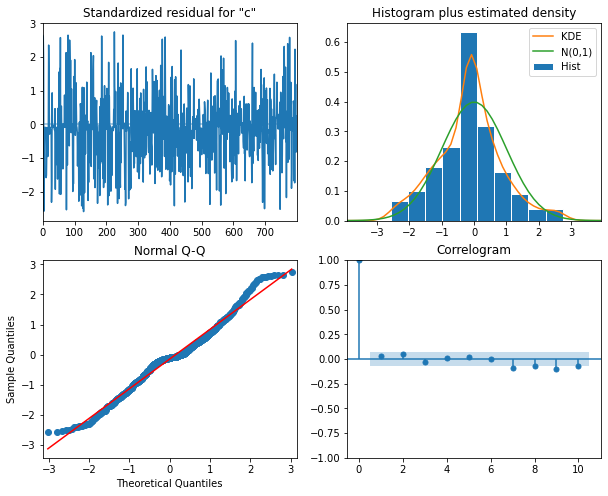

In [721]:
plt.subplots_adjust(hspace=2) # increase the space between subplots by 0.5 inches
results.plot_diagnostics(figsize=(10, 8))
plt.show()


### Prediction using the training data to evaluate the performance

In [722]:
forecast = results.get_prediction(start=-20)

In [723]:
mean_forecast = forecast.predicted_mean

In [724]:
mean_forecast= pd.DataFrame(mean_forecast)

In [725]:
confidence_intervals = forecast.conf_int()

In [726]:
confidence_intervals.head(5)

,lower close,upper close
date,,
2015-12-31,-18.688466,20.086191
2015-12-30,-18.555888,20.218769
2015-12-29,-20.103644,18.671013
2015-12-28,-19.430843,19.343814
2015-12-24,-19.008806,19.765851


In [727]:
df_train1= df_train.loc['2014']

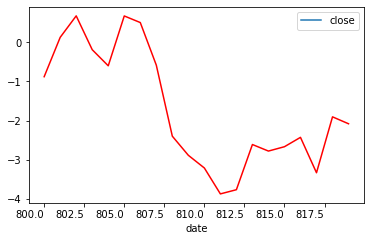

In [802]:
fig,ax= plt.subplots()
# Plot prediction
df_train1.plot(kind='line', ax= ax)
mean_forecast.plot(color='red',label='forecast', ax= ax)
# Shade uncertainty area
#plt.fill_between(x= 'date', 'lower_limits,', upper_limits, color='pink')
plt.show()

### Forecasting

In [799]:
forecast = results.get_forecast(steps=20)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [730]:
# forecast mean
mean_forecast = forecast.predicted_mean

In [731]:
# Get confidence intervals of forecasts in a dataframe
confidence_intervals = forecast.conf_int()

In [732]:
mean_forecast= pd.DataFrame(mean_forecast)

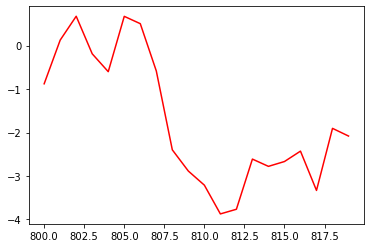

In [801]:
fig,ax= plt.subplots()
# Plot prediction
mean_forecast.plot(color='red',label='forecast', ax= ax)
# Shade uncertainty area
#plt.fill_between(x= 'date', 'lower_limits,', upper_limits, color='pink')
plt.show()

### Reconstructing the Time Series

In [734]:
diff_forecast = results.get_forecast(steps=20).predicted_mean
from numpy import cumsum
mean_forecast = cumsum(diff_forecast) + df_test.iloc[-1,0]

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [735]:
mean_forecast

800   -0.878580
801    0.127197
802    0.676448
803   -0.188437
804   -0.599813
805    0.674064
806    0.505419
807   -0.583250
808   -2.398870
809   -2.887205
810   -3.211618
811   -3.873691
812   -3.766547
813   -2.611839
814   -2.779034
815   -2.667819
816   -2.428636
817   -3.333183
818   -1.904460
819   -2.081216
Name: predicted_mean, dtype: float64

## Using Scikit-Learn For Time Series Data

##### Creating features over time

Timeseries data almost always have information that is shared between timepoints
Information in the past can help predict what happens in the future.
Often the features best-suited to predict a timeseries are previous values of the same
timeseries.

In [736]:
feats = amazon_df.rolling(20).aggregate([np.std, np.max]).dropna()
print(feats.head(3))

                close         
                  std     amax
date                          
2019-01-11  34.262776  1718.73
2019-01-10  31.115370  1718.73
2019-01-09  29.799842  1718.73


array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

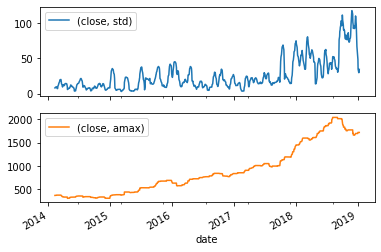

In [737]:
feats.plot(subplots=True)

In [738]:
# create lags
data = pd.Series(amazon_df.close)

In [739]:
# Shifts
shifts = [0, 1, 2, 3, 4, 5, 6, 7]
# Create a dictionary of time-shifted data
many_shifts = {'lag_{}'.format(ii): data.shift(ii) for ii in shifts}
# Convert them into a dataframe
many_shifts = pd.DataFrame(many_shifts)

In [740]:
many_shifts

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,
2019-02-08,1588.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-07,1614.37,1588.22,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-06,1640.26,1614.37,1588.22,NaN,NaN,NaN,NaN,NaN
2019-02-05,1658.81,1640.26,1614.37,1588.22,NaN,NaN,NaN,NaN
2019-02-04,1633.31,1658.81,1640.26,1614.37,1588.22,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2014-02-14,357.35,353.65,347.38,349.80,346.76,351.78,358.32,359.80
2014-02-13,357.20,357.35,353.65,347.38,349.80,346.76,351.78,358.32
2014-02-12,349.25,357.20,357.35,353.65,347.38,349.80,346.76,351.78


In [741]:
many_shifts.fillna(0,inplace=True)

#### Implementing Ridge Model to avoid over -fitting of the data

In [742]:
from sklearn.linear_model import Ridge

In [743]:
model = Ridge()
model.fit(many_shifts, data)

Ridge()

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

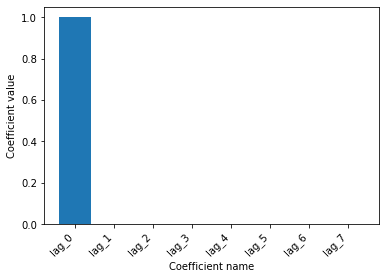

In [744]:
# Visualize the fit model coefficients
fig, ax = plt.subplots()
ax.bar(many_shifts.columns, model.coef_)
ax.set(xlabel='Coefficient name', ylabel='Coefficient value')
# Set formatting so it looks nice
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

### Cross-Validation using TimeSeriesSplit

In [745]:
from sklearn.model_selection import TimeSeriesSplit,cross_val_score

In [746]:
cv = TimeSeriesSplit(n_splits=5)

In [747]:
X= many_shifts.values
y = data.values

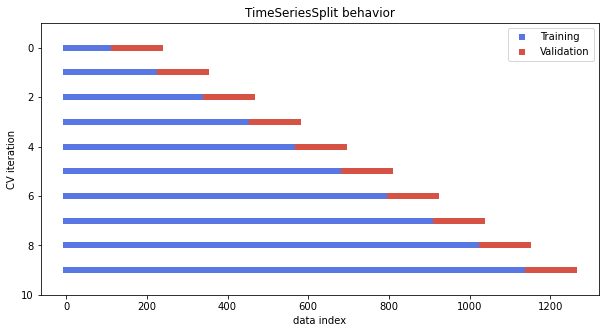

In [748]:
from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=10)
fig, ax = plt.subplots(figsize=(10, 5))
for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Plot training and test indices
    l1 = ax.scatter(tr, [ii] * len(tr), c=[plt.cm.coolwarm(.1)],
    marker='_', lw=6)
    l2 = ax.scatter(tt, [ii] * len(tt), c=[plt.cm.coolwarm(.9)],
    marker='_', lw=6)
    ax.set(ylim=[10, -1], title='TimeSeriesSplit behavior',
    xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['Training', 'Validation'])

In [749]:
for tr, tt in cv.split(X,y):
    model.fit(X[tr], y[tr])
    print(model.score(X[tt], y[tt]))

0.9999999999998493
0.999999999999729
0.9999999999996798
0.9999999999999469
0.9999999999999792
0.9999999999999852
0.9999999999999943
0.9999999999999912
0.9999999999999635
0.9999999999999879


In [750]:
tscv = TimeSeriesSplit(n_splits=5)

# Use the TimeSeriesSplit object as the cv parameter in cross_val_score
scores = cross_val_score(model, X, y, cv=tscv)

# Print the mean and standard deviation of the scores
print("Mean score: ", np.mean(scores))
print("Standard deviation: ", np.std(scores))

Mean score:  0.9999999999999221
Standard deviation:  1.2349117053489e-13


#### Visualising the CV Behaivour for Time Series Split

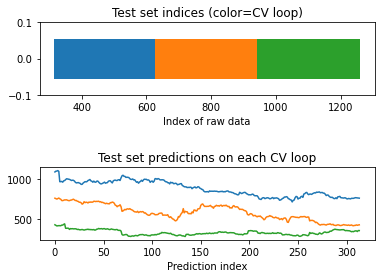

In [751]:
cv = TimeSeriesSplit(n_splits=3)
fig, axs = plt.subplots(2, 1)
plt.subplots_adjust(hspace=1) # hspace controls the height space between subplots
for tr, tt in cv.split(X,y):
    model.fit(X[tr], y[tr])
    # Plot the indices chosen for validation on each loop
    axs[0].scatter(tt, [0] * len(tt), marker='_', s=2, lw=40)
    axs[0].set(ylim=[-.1, .1], title='Test set indices (color=CV loop)',
    xlabel='Index of raw data')
    # Plot the model predictions on each iteration
    axs[1].plot(model.predict(X[tt]))
    axs[1].set(title='Test set predictions on each CV loop',
    xlabel='Prediction index')

#### Splitting the data into training and testing 

In [610]:
len(amazon_df)

1259

In [611]:
train= amazon_df.iloc[:800]
test= amazon_df.iloc[800:]

In [612]:
len(train), len(test)

(800, 459)

In [613]:
model = Ridge()

### Training

In [615]:
# create lags
data = pd.Series(train.close)

In [616]:
# Shifts
shifts = [0, 1, 2, 3, 4, 5, 6, 7]
# Create a dictionary of time-shifted data
many_shifts = {'lag_{}'.format(ii): data.shift(ii) for ii in shifts}
# Convert them into a dataframe
many_shifts = pd.DataFrame(many_shifts)

In [617]:
many_shifts.fillna(0,inplace=True)

In [618]:
model = Ridge()

In [619]:
model.fit(many_shifts.values, train.close.values)

Ridge()

### Prediction

In [620]:
# create lags
data1 = pd.Series(test.close)

In [621]:
# Shifts
shifts = [0, 1, 2, 3, 4, 5, 6, 7]
# Create a dictionary of time-shifted data
many_shifts1 = {'lag_{}'.format(ii): data1.shift(ii) for ii in shifts}
# Convert them into a dataframe
many_shifts1 = pd.DataFrame(many_shifts1)

In [624]:
many_shifts1.fillna(0,inplace=True)

In [625]:
prediction= model.predict(many_shifts1.values)

In [626]:
model.score(many_shifts1.values, test.close.values)

0.9999999999999869

In [629]:
pred_actual= pd.DataFrame({'Prediction':prediction, 'Actual': test.close.values})

In [631]:
pred_actual.head()

,Prediction,Actual
0,666.249779,666.25
1,676.010002,676.01
2,679.060005,679.06
3,664.800010,664.80
4,673.259997,673.26


### Stablity 

1. Stationary time series do not change their statistical properties over time. E.g., mean, standard deviation, trends.
3. Most time series are non-stationary to some extent.

Model stability
Non-stationary data results in variability in our model
The statistical properties the model ,nds may change with the data
In addition, we will be less certain about the correct values of model parameters
How can we quantify using Cross validation and bootstrapping

Cross validation to quantify parameter stability
One approach: use cross-validation
Calculate model parameters on each iteration
Assess parameter stability across all CV splits

Bootstrapping the mean
Bootstrapping is a common way to assess variability
The bootstrap:
1. Take a random sample of data with replacement
2. Calculate the mean of the sample
3. Repeat this process many times (1000s)
4. Calculate the percentiles of the result (usually 2.5, 97.5)
The result is a 95% con,dence interval of the mean of each coe)cient.

In [752]:
from sklearn.utils import resample

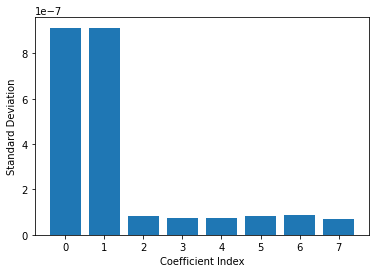

In [760]:
from sklearn.utils import resample

# Define the number of bootstrap samples to generate
n_samples = 1000

# Create empty array to collect coefficients
coefficients = np.zeros([n_samples, X.shape[1]])

# Generate bootstrap samples
for i in range(n_samples):
    # Generate a bootstrap sample of the data
    X_bootstrap, y_bootstrap = resample(X, y)
    # Fit the model on the bootstrap sample
    model.fit(X_bootstrap, y_bootstrap)
    # Collect the coefficients
    coefficients[i] = model.coef_

# Calculate the standard deviation of the coefficients
coef_std = np.std(coefficients, axis=0)

# Plot the coefficient standard deviation
plt.bar(range(X.shape[1]), coef_std)
plt.xlabel('Coefficient Index')
plt.ylabel('Standard Deviation')
plt.show()


In [788]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit

# Initialize Ridge model
model = Ridge()

# Define the number of folds for TimeSeriesSplit
n_splits = 100
cv = TimeSeriesSplit(n_splits=n_splits)

# Create empty array to collect coefficients
coefficients = np.zeros([n_splits, X.shape[1]])

# Perform TimeSeriesSplit cross-validation
for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Fit the model on training data and collect the coefficients
    model.fit(X[tr], y[tr])
    coefficients[ii] = model.coef_




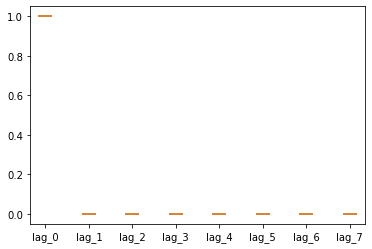

In [790]:
n_boots = 100
bootstrap_means = np.zeros([n_boots, 8])
for ii in range(n_boots):
# Generate random indices for our data with replacement,
# then take the sample mean
    random_sample = resample(coef)
    random_sample = resample(coefficients)
    bootstrap_means[ii] = random_sample.mean(axis=0)
# Compute the percentiles of choice for the bootstrapped means
percentiles = np.percentile(bootstrap_means, (2.5, 97.5), axis=0)
fig, ax = plt.subplots()
ax.scatter(many_shifts.columns, percentiles[0], marker='_', s=200)
ax.scatter(many_shifts.columns, percentiles[1], marker='_', s=200)

##### Here, I am getting a constant graph, it means that the bootstrap means for all coefficients are the same. This could mean that the model's coefficients are not changing much between bootstrap samples, indicating that the model is relatively stable.